In [8]:
pip install ucimlrepo

In [9]:
# SETUP & IMPORTS
import os
import joblib  # Untuk menyimpan model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library Machine Learning
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Membuat folder untuk menyimpan hasil (Artifacts)
os.makedirs('models', exist_ok=True)
os.makedirs('images', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [10]:
# DATA LOADING & CLEANING
print("Sedang mengambil dataset dari UCI Repository...")
from ucimlrepo import fetch_ucirepo
toxicity = fetch_ucirepo(id=728)

# Mengambil fitur dan target
X_raw = toxicity.data.features
y_raw = toxicity.data.targets

# Menggabungkan Fitur dan Target menjadi satu DataFrame
raw_dataset = pd.concat([X_raw, y_raw], axis=1)

# Simpan ke file
raw_dataset.to_csv('data/toxicity_raw_data.csv', index=False)
print("Berhasil! File tersimpan sebagai 'toxicity_raw_data.csv'.")

print(f"Dataset Asli: {X_raw.shape[0]} Baris, {X_raw.shape[1]} Fitur")

print("\n[Tabel] 5 Baris Pertama Data MENTAH (Sebelum Cleaning):")
display(X_raw.head()) # Menampilkan tabel awal

# Cek Missing Values & Cleaning
print("\n--- Proses Cleaning ---")
missing_count = X_raw.isnull().sum().sum()
if missing_count > 0:
    print(f"Ditemukan {missing_count} missing values.")
    print("Melakukan imputasi (mengisi nilai kosong) dengan rata-rata...")
    X_raw.fillna(X_raw.mean(), inplace=True)
    print("Imputasi selesai.")
else:
    print("Data sudah bersih (Tidak ada missing values).")

# --- MENAMPILKAN DATA SETELAH CLEANING ---
print("\n[Tabel] 5 Baris Pertama Data BERSIH (Setelah Cleaning):")
display(X_raw.head()) # Menampilkan tabel setelah dibersihkan

# Encoding Target (Mengubah 'Toxic'/'NonToxic' menjadi 1/0)
print("\n--- Encoding Target ---")
le = LabelEncoder()
# Mengambil kolom pertama dari y_raw karena y_raw adalah DataFrame
y_encoded = le.fit_transform(y_raw.iloc[:, 0])
y = pd.Series(y_encoded, name='Target')

# Simpan mapping kelas untuk referensi nanti
class_names = le.classes_
print(f"Mapping Kelas: {class_names} -> [0, 1]")

Sedang mengambil dataset dari UCI Repository...
Berhasil! File tersimpan sebagai 'toxicity_raw_data.csv'.
Dataset Asli: 171 Baris, 1203 Fitur

[Tabel] 5 Baris Pertama Data MENTAH (Sebelum Cleaning):


,MATS3v,nHBint10,MATS3s,MATS3p,nHBDon_Lipinski,minHBint8,MATS3e,MATS3c,minHBint2,MATS3m,...,WTPT-3,WTPT-4,WTPT-5,ETA_EtaP_L,ETA_EtaP_F,ETA_EtaP_B,nT5Ring,SHdNH,ETA_dEpsilon_C,MDEO-22
0,0.0908,0,0.0075,0.0173,0,0.0,-0.0436,0.0409,0.0,0.1368,...,0.0000,0.0000,0.0000,0.1780,1.5488,0.0088,0,0.0,-0.0868,0.00
1,0.0213,0,0.1144,-0.0410,0,0.0,0.1231,-0.0316,0.0,0.1318,...,28.2185,8.8660,19.3525,0.1739,1.3718,0.0048,2,0.0,-0.0810,0.25
2,0.0018,0,-0.0156,-0.0765,2,0.0,-0.1138,-0.1791,0.0,0.0615,...,33.1064,5.2267,27.8796,0.1688,1.4395,0.0116,2,0.0,-0.1004,0.00
3,-0.0251,0,-0.0064,-0.0894,3,0.0,-0.0747,-0.1151,0.0,0.0361,...,32.5232,7.7896,24.7336,0.1702,1.4654,0.0133,2,0.0,-0.1010,0.00
4,0.0135,0,0.0424,-0.0353,0,0.0,-0.0638,0.0307,0.0,0.0306,...,32.0726,12.3240,19.7486,0.1789,1.4495,0.0120,2,0.0,-0.1071,0.00



--- Proses Cleaning ---
Data sudah bersih (Tidak ada missing values).

[Tabel] 5 Baris Pertama Data BERSIH (Setelah Cleaning):


,MATS3v,nHBint10,MATS3s,MATS3p,nHBDon_Lipinski,minHBint8,MATS3e,MATS3c,minHBint2,MATS3m,...,WTPT-3,WTPT-4,WTPT-5,ETA_EtaP_L,ETA_EtaP_F,ETA_EtaP_B,nT5Ring,SHdNH,ETA_dEpsilon_C,MDEO-22
0,0.0908,0,0.0075,0.0173,0,0.0,-0.0436,0.0409,0.0,0.1368,...,0.0000,0.0000,0.0000,0.1780,1.5488,0.0088,0,0.0,-0.0868,0.00
1,0.0213,0,0.1144,-0.0410,0,0.0,0.1231,-0.0316,0.0,0.1318,...,28.2185,8.8660,19.3525,0.1739,1.3718,0.0048,2,0.0,-0.0810,0.25
2,0.0018,0,-0.0156,-0.0765,2,0.0,-0.1138,-0.1791,0.0,0.0615,...,33.1064,5.2267,27.8796,0.1688,1.4395,0.0116,2,0.0,-0.1004,0.00
3,-0.0251,0,-0.0064,-0.0894,3,0.0,-0.0747,-0.1151,0.0,0.0361,...,32.5232,7.7896,24.7336,0.1702,1.4654,0.0133,2,0.0,-0.1010,0.00
4,0.0135,0,0.0424,-0.0353,0,0.0,-0.0638,0.0307,0.0,0.0306,...,32.0726,12.3240,19.7486,0.1789,1.4495,0.0120,2,0.0,-0.1071,0.00



--- Encoding Target ---
Mapping Kelas: ['NonToxic' 'Toxic'] -> [0, 1]


In [11]:
# FEATURE ENGINEERING
print("Melakukan Seleksi Fitur...")

selector = SelectKBest(score_func=f_classif, k=30)
X_selected = selector.fit_transform(X_raw, y)

# Mendapatkan nama fitur yang terpilih
mask = selector.get_support()
selected_features = X_raw.columns[mask]

# Membuat DataFrame baru dengan fitur terpilih
X_final = pd.DataFrame(X_selected, columns=selected_features)

print(f"Dimensi Awal: {X_raw.shape}")
print(f"Dimensi Setelah Seleksi: {X_final.shape}")
print(f"Fitur Terpilih: {list(selected_features[:5])} ...") # Print 5 fitur pertama

Melakukan Seleksi Fitur...
Dimensi Awal: (171, 1203)
Dimensi Setelah Seleksi: (171, 30)
Fitur Terpilih: ['minHBint4', 'MDEC-23', 'SP-5', 'SpAD_Dt', 'AATS8m'] ...


In [12]:
# DATA TRANSFORMATION
scaler = StandardScaler()

# Melakukan scaling pada X_final
X_scaled_array = scaler.fit_transform(X_final)
X_scaled = pd.DataFrame(X_scaled_array, columns=selected_features)

print("Beberapa data setelah scaling:")
print(X_scaled.iloc[:3, :5]) # Print 3 baris pertama, 5 kolom pertama

Beberapa data setelah scaling:
   minHBint4   MDEC-23      SP-5   SpAD_Dt    AATS8m
0  -0.431683  2.092225  3.110567  5.936024  1.267854
1  -0.431683  0.533787  0.610742  0.547833  0.623250
2  -0.431683 -0.157729  0.618642  1.135513 -0.079443


In [15]:
# SIMPAN PROCESSED DATA

processed_dataset = pd.concat([X_scaled, y], axis=1)

processed_dataset.to_csv('data/toxicity_processed_data.csv', index=False)
print("Berhasil! File 'toxicity_processed_data.csv' siap digunakan untuk modelling.")

Berhasil! File 'toxicity_processed_data.csv' siap digunakan untuk modelling.


In [16]:
processed_dataset.head()

,minHBint4,MDEC-23,SP-5,SpAD_Dt,AATS8m,AATS8v,SpMax4_Bhm,ETA_Eta_F_L,SpDiam_Dt,nC,...,GATS7v,SpMin4_Bhs,SpMin4_Bhi,SpMax_Dt,MLogP,nwHBa,ZMIC1,AATSC7p,SpMAD_Dt,Target
0,-0.431683,2.092225,3.110567,5.936024,1.267854,2.048872,0.968588,1.921522,4.238009,1.574333,...,0.370688,0.869164,1.181270,5.968571,1.418220,-4.183958,2.023033,0.410129,5.946016,0
1,-0.431683,0.533787,0.610742,0.547833,0.623250,0.557784,0.618068,1.596874,0.857719,0.748532,...,-0.317544,0.891776,0.995288,0.555788,0.461173,1.372354,1.361793,-0.729201,0.230646,0
2,-0.431683,-0.157729,0.618642,1.135513,-0.079443,-0.217059,0.067158,1.731956,1.524037,0.542082,...,1.792366,0.827510,0.969134,1.146151,-0.113055,0.882091,-0.335577,-1.666922,0.814044,0
3,-0.431683,0.144968,0.712991,1.208194,-0.202179,-0.307730,0.068447,1.830368,1.583019,0.748532,...,2.349985,0.809063,0.969134,1.219164,0.078355,1.045512,-0.217061,-2.187356,0.784626,0
4,-0.431683,1.352274,1.000019,1.136004,0.297009,0.694521,0.967944,1.477351,1.235150,0.542082,...,0.986581,0.738846,0.991801,1.135183,-0.113055,0.882091,0.697308,-0.190012,0.814615,0


In [ ]:
# DATA SPLITTING
# Target: Train=70%, Val=15%, Test=15%

# Langkah 1: Pisahkan Test (15%) dari total data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

# Langkah 2: Pisahkan Train (70%) dan Val (15%) dari sisa data
# Hitungan: 0.15 / 0.85 (sisa) ~= 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)

print(f"Total Data: {len(X_scaled)}")
print(f"Train Set : {X_train.shape[0]} ({X_train.shape[0]/len(X_scaled):.1%})")
print(f"Val Set   : {X_val.shape[0]} ({X_val.shape[0]/len(X_scaled):.1%})")
print(f"Test Set  : {X_test.shape[0]} ({X_test.shape[0]/len(X_scaled):.1%})")
print("✅ Data Splitting Selesai.")

Total Data: 171
Train Set : 119 (69.6%)
Val Set   : 26 (15.2%)
Test Set  : 26 (15.2%)
✅ Data Splitting Selesai.


In [ ]:
# DATA BALANCING
# Kita gunakan teknik Class Weighting (bukan oversampling) untuk menjaga keaslian data
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weights[i] for i in range(len(weights))}

print(f"Class Weights: {class_weight_dict}")

Class Weights: {0: np.float64(0.74375), 1: np.float64(1.5256410256410255)}


In [ ]:
# MODEL 1 - BASELINE (Logistic Regression)
print("Training Baseline Model...")
model_baseline = LogisticRegression(random_state=42, class_weight='balanced')
model_baseline.fit(X_train, y_train)

# Simpan Model
joblib.dump(model_baseline, 'models/model_baseline.pkl')
print("✅ Baseline Model Trained & Saved.")

Training Baseline Model...
✅ Baseline Model Trained & Saved.


In [ ]:
# MODEL 2 - ADVANCED (Random Forest)
print("Training Advanced Model...")
# Menggunakan n_estimators=100 dan max_depth dibatasi agar tidak overfitting di data kecil
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_rf.fit(X_train, y_train)

# Simpan Model
joblib.dump(model_rf, 'models/model_advanced.pkl')
print("✅ Advanced Model Trained & Saved.")

Training Advanced Model...
✅ Advanced Model Trained & Saved.


In [ ]:
# MODEL 3 - DEEP LEARNING (MLP)
print("Training Deep Learning Model...")

# Arsitektur Model
# Karena data sedikit, kita gunakan Dropout yang cukup besar untuk mencegah overfitting
model_dl = Sequential([
    Input(shape=(X_train.shape[1],)),       # Input Layer (30 fitur)
    Dense(64, activation='relu'),           # Hidden Layer 1
    Dropout(0.5),
    Dense(32, activation='relu'),           # Hidden Layer 2
    Dropout(0.3),
    Dense(1, activation='sigmoid')          # Output Layer (Binary)
])

model_dl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping
history = model_dl.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,             # Maksimum epoch
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=0,              # Silent training agar tidak penuh outputnya
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

# Simpan Model
model_dl.save('models/model_toxicity_dl.keras')
print("✅ Deep Learning Model Trained & Saved.")

Training Deep Learning Model...
✅ Deep Learning Model Trained & Saved.


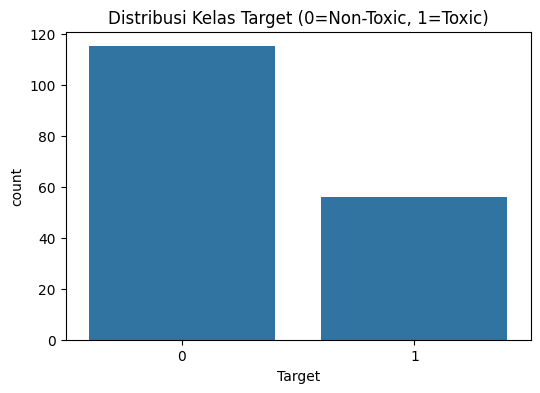

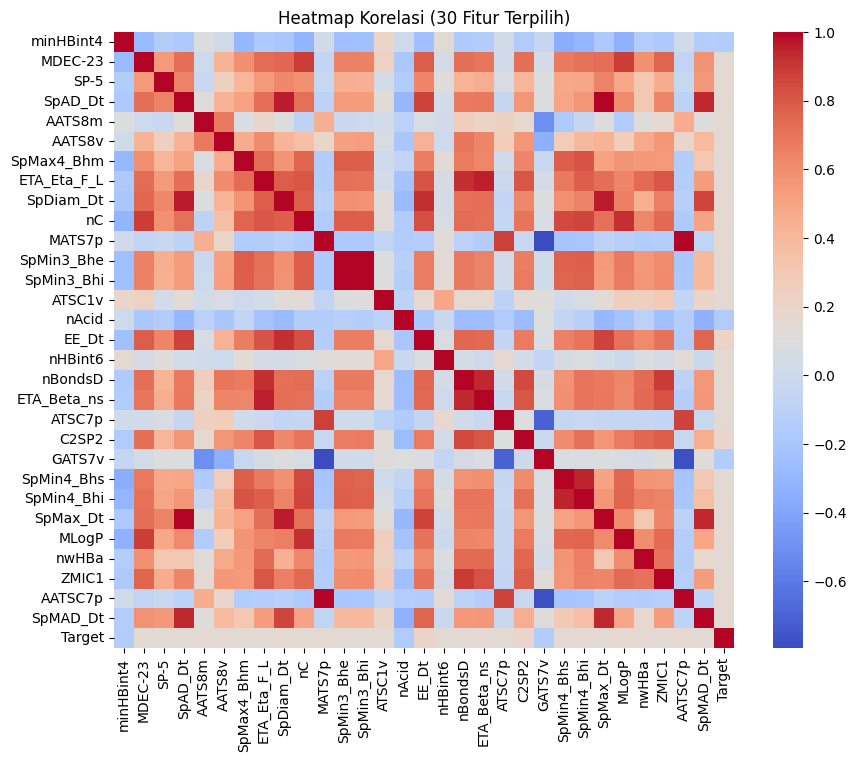

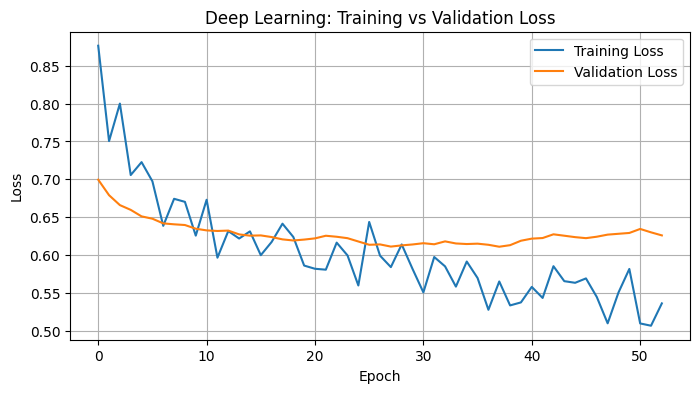

✅ Visualisasi selesai dan disimpan di folder 'images/'.


In [ ]:
# VISUALIZATION

# 1. Visualisasi Distribusi Kelas Target
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribusi Kelas Target (0=Non-Toxic, 1=Toxic)')
plt.savefig('images/viz1_class_distribution.png') # Save
plt.show()

# 2. Visualisasi Heatmap Korelasi (Fitur Terpilih)
plt.figure(figsize=(10, 8))
# Menggabungkan X dan y sementara untuk korelasi
df_corr = X_final.copy()
df_corr['Target'] = y.values
corr = df_corr.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False) # Annot false agar tidak penuh angka
plt.title('Heatmap Korelasi (30 Fitur Terpilih)')
plt.savefig('images/viz2_correlation.png') # Save
plt.show()

# 3. Visualisasi Training History (Loss) untuk Deep Learning
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Deep Learning: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('images/viz3_dl_loss.png') # Save
plt.show()

print("✅ Visualisasi selesai dan disimpan di folder 'images/'.")

=== HASIL EVALUASI PADA DATA TEST (15%) ===

>> Mengevaluasi Model: Baseline (LogReg)...
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.44      0.44      0.44         9

    accuracy                           0.62        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.62      0.62      0.62        26


>> Mengevaluasi Model: Advanced (RF)...
              precision    recall  f1-score   support

           0       0.62      0.88      0.73        17
           1       0.00      0.00      0.00         9

    accuracy                           0.58        26
   macro avg       0.31      0.44      0.37        26
weighted avg       0.41      0.58      0.48        26


>> Mengevaluasi Model: Deep Learning (MLP)...
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        17
           1       0.60      0.33      0.43         9

    a

,Model,Accuracy,F1-Score
0,Baseline (LogReg),0.6154,0.6154
1,Advanced (RF),0.5769,0.4784
2,Deep Learning (MLP),0.6923,0.6645


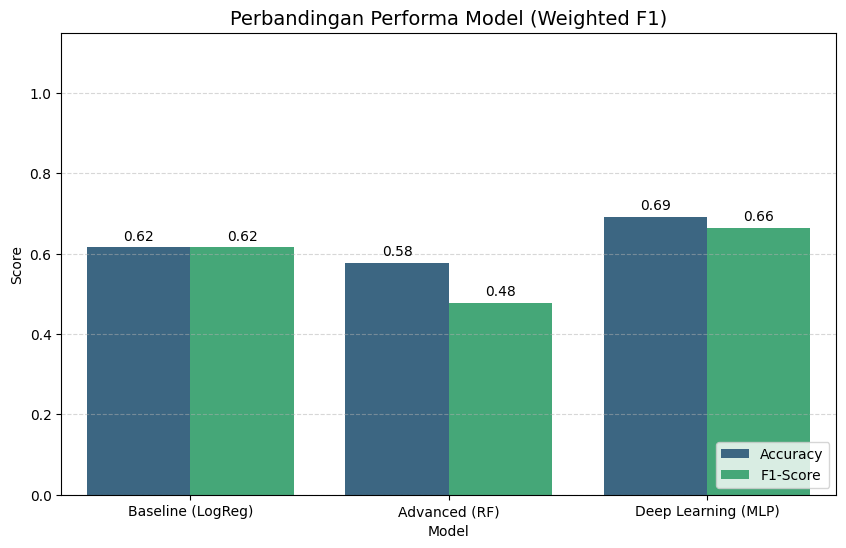

In [ ]:
# EVALUATION & COMPARISON

# 1. Pastikan Dictionary Model sudah siap
models_dict = {
    'Baseline (LogReg)': model_baseline,
    'Advanced (RF)': model_rf,
    'Deep Learning (MLP)': model_dl
}

# Container hasil
final_metrics = []

print("=== HASIL EVALUASI PADA DATA TEST (15%) ===")

for name, model in models_dict.items():
    print(f"\n>> Mengevaluasi Model: {name}...")

    # 2. Lakukan Prediksi
    if name == 'Deep Learning (MLP)':
        # Output DL adalah probabilitas, ubah jadi 0/1
        y_pred_prob = model.predict(X_test, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        # Output Sklearn langsung kelas 0/1
        y_pred = model.predict(X_test)

    # 3. Hitung Metrik
    acc = accuracy_score(y_test, y_pred)

    # Gunakan average='weighted' agar F1-Score lebih adil
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    final_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1
    })

    # Print Laporan Detail
    print(classification_report(y_test, y_pred, zero_division=0))

# 4. Membuat Tabel DataFrame
df_metrics = pd.DataFrame(final_metrics)

print("\n=== TABEL PERBANDINGAN AKHIR ===")
# --- PERBAIKAN DI SINI ---
# Kita format spesifik per kolom agar kolom 'Model' (Text) tidak error
display(df_metrics.style.format({
    'Accuracy': '{:.4f}',
    'F1-Score': '{:.4f}'
}))

# 5. Visualisasi
plt.figure(figsize=(10, 6))
df_melted = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Score")

ax = sns.barplot(data=df_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Perbandingan Performa Model (Weighted F1)", fontsize=14)
plt.ylim(0, 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# Label Angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.savefig('images/viz4_model_comparison.png')
plt.show()